In [1]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
from time import sleep
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import config

In [2]:
# disable notifications
chrome_options = Options()
chrome_options.add_argument("--disable-notifications")

In [3]:
# open facebook
driver = webdriver.Chrome(options=chrome_options) 
driver.get("https://www.facebook.com")

In [4]:
# Log in using my credentials
username = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='email']")))
password = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='pass']")))

# my_username and my_password should be replaced with your own unique values
username.clear()
username.send_keys(config.my_username)
password.clear()
password.send_keys(config.my_password)
button = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[type='submit']"))).click()
sleep(10)

In [5]:
# Open the facebook group (Student Housing in Waterloo)
driver.get('https://www.facebook.com/groups/110354088989367')
sleep(10)

In [6]:
# scroll down 40 times to gather more posts
for j in range(0,40):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    sleep(10)

In [7]:
# store all posts' html text in all_posts
soup = BeautifulSoup(driver.page_source, "html.parser")
all_posts = soup.find_all('div', attrs={'class':'du4w35lb k4urcfbm l9j0dhe7 sjgh65i0'})

In [8]:
len(all_posts) # should check that we have 200+ posts

247

In [9]:
# This function takes in the message from each post, and returns the number of bedrooms specified in the post
def get_bedrooms(my_str):
    d1 = re.search('([^ \r\n]+) beds?', my_str, re.IGNORECASE)
    d2 = re.search('([^ \r\n]+) bedrooms?', my_str, re.IGNORECASE)
    if d1:
        beds = d1.group(0)
    elif d2:
        beds = d2.group(0)
    else:
        beds = 1 # one bedroom by default if not specified
    return beds

In [10]:
# testing the above function get_bedrooms: 
msg = '2 Beds 1 Bath - Apartment203 Albert St, Waterloo, ON N2L 3T4, Canada'
print('bedroom:', get_bedrooms(msg))

bedroom: 2 Beds


In [11]:
# This function takes in the message from each post, and returns a Boolean value to indicate whether the post is
#   looking for a housing (True), or is in search for a housing (False)
def is_looking(my_str):
    my_str = my_str.lower()
    if 'looking'in my_str:
        return True
    elif 'available' or 'offering' in my_str:
        return False
    else:
        return None

In [12]:
# initializes lists that will later be columns for a new dataframe
price_list = []
bedrooms_list = []
isLookingFor_list = []

In [13]:
# parses text from each posting and append appropriate values to the lists
for post in all_posts: 
    price_text = post.find('span', attrs={'class': 'sqxagodl'}).find('div').getText()
    try: 
        price = ''.join([n for n in price_text.split()[0] if n.isdigit()])
        if price == '':
            price = 0
    except: 
        price = 0
    
    message_text = post.find('div', attrs={'data-ad-comet-preview':'message'})
    try:
        message = str(message_text.getText())
    except:
        message = ''

    bedroom_text = get_bedrooms(message)
    try: 
        bedroom = ''.join([n for n in str(bedroom_text).split()[0] if n.isdigit()])
        if bedroom == '':
            bedroom = 1
    except:
        bedroom = 1 # 1 bedroom by default if not specified

    if int(price) >= 1600: # if price is above 1600, assume that it's total price for the entire unit
        price = int(price) // int(bedroom)

    price_list.append(int(price))
    bedrooms_list.append(int(bedroom))
    isLookingFor_list.append(is_looking(message))

In [14]:
# a quick check to see if data was parsed correctly
price_list[:10], bedrooms_list[:10], isLookingFor_list[:10]

([900, 1400, 1, 1, 1250, 600, 1000, 860, 1150, 746],
 [1, 2, 1, 1, 1, 1, 1, 1, 1, 1],
 [True, False, True, True, True, True, True, True, True, True])

In [15]:
len(price_list), len(bedrooms_list)

(247, 247)

In [16]:
data = {'price': price_list, 'bedroom': bedrooms_list, 'isLookingFor': isLookingFor_list}

In [17]:
# a new dataframe to store price, number of bedrooms, and a boolean value isLookingFor
df = pd.DataFrame(data)
df.to_excel('housing_list.xlsx', index=False)
df.head()

,price,bedroom,isLookingFor
0,900,1,True
1,1400,2,False
2,1,1,True
3,1,1,True
4,1250,1,True


#### To read from the excel file instead of scraping from facebook each time

In [18]:
df = pd.read_excel('housing_list.xlsx')

In [19]:
# ignore rows with extraordinary values (since people might be either putting numbers like $1, $100, $123456, $999999, or might be looking for a parking spot at a lower price)
df.drop(df[(df.price < 300) | (df.price > 2000)].index, inplace=True)
df.drop(df[df.bedroom > 7].index, inplace=True) # assume there are no more bedrooms than 7

In [20]:
# a quick check
df.groupby('isLookingFor').describe()

price                                                       \
             count        mean         std    min    25%    50%     75%   
isLookingFor                                                              
False         59.0  967.491525  384.787150  300.0  700.0  900.0  1250.0   
True          91.0  948.076923  331.718798  300.0  750.0  900.0  1000.0   

                     bedroom                                               
                 max   count      mean       std  min  25%  50%  75%  max  
isLookingFor                                                               
False         2000.0    59.0  1.355932  0.866278  1.0  1.0  1.0  1.0  5.0  
True          2000.0    91.0  1.252747  0.797125  1.0  1.0  1.0  1.0  5.0

In [21]:
df.groupby('bedroom').describe()

price                                                              
         count      mean         std    min     25%     50%      75%     max
bedroom                                                                     
1        125.0   962.736  366.030079  300.0  750.00   900.0  1150.00  2000.0
2         17.0  1037.000  258.465181  500.0  879.00  1000.0  1300.00  1400.0
3          2.0   595.500   41.719300  566.0  580.75   595.5   610.25   625.0
4          1.0   800.000         NaN  800.0  800.00   800.0   800.00   800.0
5          5.0   679.000   94.101010  550.0  640.00   675.0   730.00   800.0

In [22]:
# separate data by number of bedrooms
by_bedroom = df.groupby('bedroom')

In [23]:
bedroom_labels = []
bedroom_values = []
price_by_bedroom = {}

In [24]:
# store key (bedroom number) and value (average price) in the variable price_by_bedroom
for idx, frame in by_bedroom:
    bedroom_labels.append(idx)
    bedroom_values.append(by_bedroom.size()[idx])
    price_by_bedroom[idx] = by_bedroom.mean().loc[idx, 'price']

In [25]:
price_by_bedroom

{1: 962.736, 2: 1037.0, 3: 595.5, 4: 800.0, 5: 679.0}

In [26]:
# a function for specific percentage format (for the pie chart)
def custom_autopct(pct): 
    return '{:.1f}%'.format(pct) if pct >= 5 else ''

In [27]:
total_bedrooms = sum(bedroom_values) # number of total bedrooms to calculate the percentage later on
total_bedrooms

150

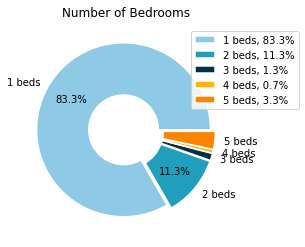

In [28]:
# A pie chart for Distribution of Number of Bedrooms
colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']
explode = [0.03] * 5
labels = [str(s) + ' beds' for s in bedroom_labels]
wedgeprops = {'width': 0.6, 'edgecolor':'w', 'linewidth': 1.5}
plt.pie(bedroom_values, labels=labels, colors=colors, autopct=custom_autopct, explode=explode, wedgeprops=wedgeprops, pctdistance=0.7)
plt.title("Number of Bedrooms")

bedroom_percent = (bedroom_values / total_bedrooms) * 100
legend_labels = [f'{l}, {s:0.1f}%' for l, s in zip(labels, bedroom_percent)]
plt.legend(loc=(0.8, 0.6), labels=legend_labels)

plt.savefig('Graphs/byBedroom.png', dpi=100)
plt.show()

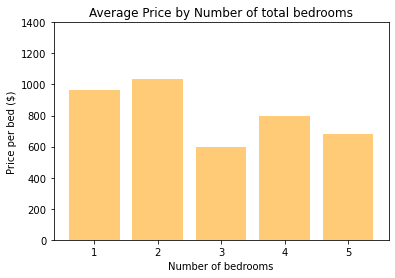

In [29]:
# A Bar Graph for Average Price per room (by Number of total bedrooms)
plt.bar(price_by_bedroom.keys(), price_by_bedroom.values(), color='#ffcb77')
plt.ylim(0, 1400)
plt.title("Average Price by Number of total bedrooms")
plt.xlabel('Number of bedrooms')
plt.ylabel('Price per bed ($)')
plt.savefig('Graphs/priceByBedroom.png', dpi=100)
plt.show()

In [30]:
searchCount = df[df['isLookingFor'] == True].shape[0]
offerCount = df[df['isLookingFor'] == False].shape[0]

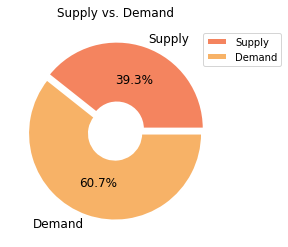

In [33]:
# A pie chart to compare supply and demand
my_values = [offerCount, searchCount]
my_labels = ['Supply', 'Demand']
colors = ['#f4845f', '#f7b267']
explode = [0.03] * 2
wedgeprops = {'width': 0.7, 'edgecolor':'w', 'linewidth':2}
textprops = {"fontsize":12}
plt.pie(my_values, labels=my_labels, explode=explode, autopct = "%0.1f%%", colors=colors, wedgeprops=wedgeprops, textprops=textprops)
plt.title('Supply vs. Demand')
plt.legend(loc=(0.9, 0.8))
plt.savefig('Graphs/supply_vs_demand.png', dpi=100)
plt.show()

In [34]:
# a new dataframe to store average price, for Supply and Demand individually
avg_price = pd.DataFrame(bedroom_labels, columns=['bedroom'])

In [35]:
df_searches = df.groupby('isLookingFor').get_group(True).groupby('bedroom').mean()['price']
df_offers = df.groupby('isLookingFor').get_group(False).groupby('bedroom').mean()['price']

In [36]:
# min and max calculated to be used in the bar graph later (we want this here before inserting zeros)
min_price = min(list(df_searches) + list(df_offers))
max_price = max(list(df_searches) + list(df_offers))
min_price, max_price

(595.5, 1107.9)

In [38]:
avg_price['Searches'] = np.arange(5)
avg_price['Offers'] = np.arange(5)

# insert the average price for each row (number of bedrooms) and column (isLookingFor)
for i, value in enumerate(bedroom_labels):
    if value in df_searches.index:
        avg_price.iloc[i, 1] = round(df_searches[value], 1)
    else: 
        avg_price.iloc[i, 1] = 0
        
    if value in df_offers.index:
        avg_price.iloc[i, 2] = round(df_offers[value], 1)
    else:
        avg_price.iloc[i, 2] = 0

In [39]:
avg_price

,bedroom,Searches,Offers
0,1,966.6,956.0
1,2,935.7,1107.9
2,3,595.5,0.0
3,4,0.0,800.0
4,5,723.3,612.5


In [43]:
bedroom_labels

[1, 2, 3, 4, 5]

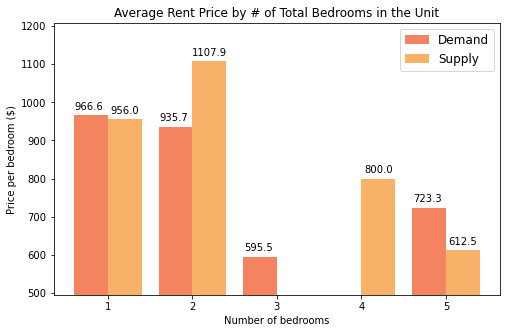

In [44]:
plt.figure(figsize=(8, 5))
plt.title('Average Rent Price by # of Total Bedrooms in the Unit')

searches_bar = plt.bar(bedroom_labels, avg_price['Searches'], width=-0.4, align='edge', label='Demand', color='#f4845f')
offers_bar = plt.bar(bedroom_labels, avg_price['Offers'], width=0.4, align='edge', label='Supply', color='#f7b267')

plt.ylim(min_price - 100, max_price + 100)
plt.legend(ncol=1, prop={'size': 12}, loc=1)
plt.xlabel('Number of bedrooms')
plt.ylabel('Price per bedroom ($)')

for idx, rect in enumerate(searches_bar): 
    if rect.get_height():
        plt.text(idx+0.78, rect.get_height() + 15, avg_price['Searches'][idx], ha='center', color='black')

for idx, rect in enumerate(offers_bar):
    if rect.get_height():
        plt.text(idx+1.2, rect.get_height() + 15, avg_price['Offers'][idx], ha='center', color='black')

plt.savefig('Graphs/compare_price_searches_offers.png', dpi=100)
plt.show()